<a href="https://colab.research.google.com/github/Hbasgol/qlearningwithfunctionapproximation/blob/master/qlearing_approximation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 0, score 10.


Episode 200, score 14.
Episode 400, score 77.
Episode 600, score 23.
Episode 800, score 354.
◙ Played 996 episodes. Solved after total 107048 trials, current mean 250.92
Episode 1000, score 415.


Scores of the agent: [10, 14, 12, 16, 11, 13, 21, 29, 13, 10, 17, 17, 12, 8, 26, 11, 16, 12, 27, 15, 11, 10, 10, 28, 15, 11, 14, 15, 10, 9, 11, 12, 38, 14, 12, 13, 13, 19, 42, 19, 13, 18, 46, 20, 34, 19, 19, 34, 17, 59, 16, 19, 22, 25, 19, 16, 15, 23, 17, 28, 16, 18, 20, 11, 15, 24, 13, 16, 12, 24, 23, 17, 10, 15, 15, 25, 12, 16, 28, 16, 11, 16, 59, 12, 24, 50, 19, 22, 21, 35, 17, 18, 24, 84, 16, 21, 30, 43, 17, 32, 17, 18, 18, 18, 13, 20, 28, 23, 24, 12, 17, 14, 22, 47, 14, 11, 14, 26, 11, 16, 19, 51, 44, 30, 23, 12, 53, 31, 18, 32, 21, 10, 12, 42, 39, 16, 24, 13, 18, 21, 13, 12, 19, 39, 17, 10, 21, 18, 11, 14, 20, 36, 46, 47, 27, 47, 13, 17, 18, 17, 23, 21, 16, 13, 55, 43, 41, 16, 49, 31, 36, 43, 11, 15, 10, 31, 42, 25, 14, 20, 28, 54, 120, 12, 22, 41, 29, 20, 56, 35, 12, 13, 14, 31, 51, 34, 19, 14, 26, 34, 14, 17, 63, 33, 47, 14, 14, 33, 31, 22, 38, 71, 14, 23, 40, 18, 64, 17, 21, 12, 28, 15, 16, 32, 20, 33, 32, 30, 20, 45, 22, 27, 39, 21, 30, 13, 42, 30, 21, 22, 12, 10, 24, 21, 34,

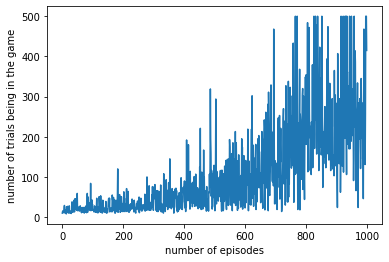

Mean of scores within 100 consecutive episodes: [20.32, 25.94, 28.92, 41.86, 67.13, 84.83, 128.45, 183.2, 244.83, 259.15]


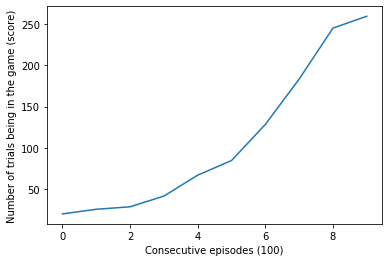

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
from gym.wrappers.monitoring import video_recorder
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.special import expit

!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!rm -rf videos
!mkdir videos

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

def show_video(trialNo = 0):
  mp4list = glob.glob('videos/*.mp4')
  mp4list.sort()
  if len(mp4list) > 0:
    mp4 = mp4list[trialNo]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    
def make_video(env, path='videos', trialNo = 0):
  video_render = video_recorder.VideoRecorder(env, './%s/trial%d.mp4' % (path, trialNo))
  return video_render

class Environment(): 
  def __init__(self, max_episodes, max_episode_steps):
    self.env = gym.make('CartPole-v0')
    self.max_episodes=max_episodes
    self.env._max_episode_steps=max_episode_steps
    
  def terminate_condition(self, observation):
    return observation[0] > -2.4 and observation[0] < 2.4
    
class Agent():
  def __init__(self, Environment, gamma=0.99):
    self.gamma=gamma
    self.env=Environment.env
    self.scores=[]
    self.rewards=[]
    self.information=[]
    
class NeuralNetwork():
  def __init__(self, Environment, hidden=5, batch_size=30, learningrate=1e-2, decay_rate=0.99):
    self.env=Environment.env
    self.H = hidden
    self.D = (self.env.observation_space.shape[0] + 1) * 1
    self.batch_size = batch_size
    self.learning_rate = learningrate
    self.decay_rate=decay_rate
    
    self.model = {}
    self.model['W1'] = np.random.randn(self.H,self.D) / np.sqrt(self.D)
    self.model['W2'] = np.random.randn(self.H) / np.sqrt(self.H)
    
    self.grad_buffer = { k : np.zeros_like(v) for k,v in self.model.items() }
    self.rmsprop_cache = { k : np.zeros_like(v) for k,v in self.model.items() }
  
  def sigmoid(self, x): 
    return 1.0 / (1.0 + np.exp(-x))

  def policy_forward(self, x):
    h = np.dot(self.model['W1'], x)
    h[h<0] = 0
    logp = np.dot(self.model['W2'], h)
    p = self.sigmoid(logp)
    return p, h

  def discount_rewards(self, Agent, r):
    discounted_r = np.zeros_like(r, dtype=np.float32)
    running_add = 0
    for t in reversed(range(0, r.size)):
      running_add = running_add * Agent.gamma + r[t]
      discounted_r[t] = running_add
    return discounted_r

  def policy_backward(self, epx, eph, epdlogp):
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, self.model['W2'])
    dh[eph <= 0] = 0
    dW1 = np.dot(dh.T, epx)
    return {'W1':dW1, 'W2':dW2}
  
  def train(self):
    for k,v in self.model.items():
      g = self.grad_buffer[k]
      self.rmsprop_cache[k] = self.decay_rate * self.rmsprop_cache[k] + (1 - self.decay_rate) * g**2
      self.model[k] += self.learning_rate * g / (np.sqrt(self.rmsprop_cache[k]) + 1e-5)
      self.grad_buffer[k] = np.zeros_like(v)
    
def Game(Agent, Environment, Network):
  observation = Environment.env.reset()
  a=0
  done_a=0
  running_reward=0
  vid=0
  game=False
  is_first=True

  xs,hs,dlogps,drs = [],[],[],[]
  reward_sum = 0
  episode_number = 0

  video = make_video(Environment.env, 'videos', vid)

  while True:
    a=a+1
    f_vector = np.append([1], observation)
    logp, h = Network.policy_forward(f_vector)
    action = 1 if np.random.uniform() < logp else 0
    xs.append(f_vector)
    hs.append(h)
    target = 1 if action == 1 else 0
    dlogps.append(target - logp) 
    
    observation, reward, done, info = Environment.env.step(action)
    reward_sum += reward

    drs.append(reward)
    
    if episode_number==0:
      video.capture_frame()
    if episode_number==Environment.max_episodes-1:
      video.capture_frame()
        
    if (done and (episode_number!=0 or episode_number==Environment.max_episodes)) or (not Environment.terminate_condition(observation) and episode_number==0):
      if episode_number==0:
        a=10
      Agent.scores.append(a)
      a=0
      epx = np.vstack(xs)
      eph = np.vstack(hs)
      epdlogp = np.vstack(dlogps)
      epr = np.vstack(drs)
      xs,hs,dlogps,drs = [],[],[],[]

      discounted_epr = Network.discount_rewards(Agent, epr)
      discounted_epr -= np.mean(discounted_epr)
      discounted_epr /= np.std(discounted_epr)
      epdlogp *= discounted_epr
      grad = Network.policy_backward(epx, eph, epdlogp)
      
      for k in Network.model: Network.grad_buffer[k] += grad[k]
      
      if episode_number % Network.batch_size == 0:
        Network.train()
        epx, eph, epdlogp, epr = [],[],[],[]
        
      running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
      Agent.information.append([(episode_number, reward_sum, running_reward)])
      if episode_number % 200 == 0:
        print ('Episode %d, score %d.' % (episode_number, Agent.scores[episode_number]))
        Agent.information.append(['Episode %d, score %d.' % (episode_number, Agent.scores[episode_number])])
      reward_sum = 0
      
      if episode_number==0:
        video.close()
        Environment.env.close()
        show_video(0)
        vid+=1
        video = make_video(Environment.env, 'videos', vid)
        
      if episode_number>=100:
        if np.mean(Agent.scores[-100:])>250 and game == False:
          print('◙ Played {} episodes. Solved after total {} trials, current mean {}'.format(episode_number, sum(Agent.scores), np.mean(Agent.scores[-100:])))
          Agent.information.append(['◙ Played {} episodes. Solved after total {} trials, current mean {}'.format(episode_number, sum(Agent.scores), np.mean(Agent.scores[-100:]))])
          game = True
          
      episode_number += 1
      observation = Environment.env.reset()

      if episode_number == Environment.max_episodes:
        print ('Episode %d, score %d.' % (episode_number, Agent.scores[episode_number-1]))
        video.close()
        Environment.env.close()
        show_video(1)
        return Agent.scores, Agent.information, episode_number
      
  return Agent.scores, Agent.information, episode_number
      
Env=Environment(1000, 500)
Ag=Agent(Env)
Nt=NeuralNetwork(Env)

scores, information, videonumber = Game(Ag, Env, Nt)

print("Scores of the agent:", scores)

plt.plot(range(0, len(scores)), scores)
plt.xlabel("number of episodes")
plt.ylabel("number of trials being in the game") 
plt.show()

mean=[]
for i in range(0, len(scores)//100):
  mean.append(np.mean(scores[i*100:(i+1)*100]))

print("Mean of scores within 100 consecutive episodes:", mean)
plt.plot(range(0, len(mean)), mean)
plt.xlabel("Consecutive episodes (100)")
plt.ylabel("Number of trials being in the game (score)") 
plt.show()